The ETL part of the analysis can be found here:
https://github.com/vosilov/Data-Science-Portfolio/blob/master/AirBnB-Kaggle-Competition/airbnb_kaggle_ETL.ipynb
The data is saved in an hdf5 file, which we will now load and start the predictive analysis. Let's first do all the imports:

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.dummy import DummyClassifier

Now we load the data from the hdf5 file saved earlier: 

In [2]:
trainDF = pd.read_hdf('airbnb_ready.h5', 'train_df')
testDF = pd.read_hdf('airbnb_ready.h5', 'test_df')

Now we need to, first, use `LabelEncoder` to label the categories of the output variable __`country_destination`__. For computational efficiency we can convert the data into sparse matrices. According to the sklearn documentation:
> _As a rule of thumb you can consider that if the sparsity ratio is greater than 90% you can probably benefit from sparse formats._

In [3]:
# Check sparsity:
def sparsity_ratio(X):
    return 1.0 - np.count_nonzero(X) / float(X.shape[0] * X.shape[1])
print("input sparsity ratio:", sparsity_ratio(trainDF))

sparse_testDF = csc_matrix(testDF.values)
X = csc_matrix(trainDF.iloc[:, 1:].values)
y = trainDF.iloc[:, 0]
le = LabelEncoder()
y = le.fit_transform(y.values)

input sparsity ratio: 0.9332431644005321


Then, after converting the data to sparse matrices, we split the training data into train/test(validation) sets:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1)

In [5]:
trainDF = 0
testDF = 0
X = 0
y = 0
# to save some memory

### Logistic Regession

Let's first fit a Logistic Regression and take a look at the 5x3 nested cross-validation score. Nested cross validation is recommended to use when selecting among competing models and simultaneously tuning their parameters in order to avoid overfitting the training data. The score we get out of a nested cross validation is a reliable estimate of how a tuned model would perform when given an unseen data.

In [34]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
pipe_lr = make_pipeline(StandardScaler(with_mean=0), logreg)

choiceofc = [10 ** c for c in np.arange(-4, 3)]
param_grid = {'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__C': choiceofc}

logreg_gs = GridSearchCV(estimator=pipe_lr, param_grid=param_grid,
                         scoring='accuracy', cv=3, n_jobs=-1)
logreg_scores = cross_val_score(logreg_gs, X_train, y_train,
                                scoring='accuracy', cv=5, n_jobs=-1)

print('Cross validated accuracy: %.3f +/- %.3f' %
      (np.mean(logreg_scores), np.std(logreg_scores)))

Cross validated accuracy: 0.696 +/- 0.002


The accuracy of a tuned Logistic Regression would be almost 70% when given new data.

### Random Forest

Next, we try a Random Forest classifier and output the mean 5x3 nested cross-validation scores, along with their standard deviation. Typically, the higher the number of trees (`n_estimators` parameter) in the forest the better the performance at the cost of increased number of computations. Here, I choose `n_estimators` = 1500. The parameter that we can think of tuning using a grid search is the maximum number of features in each tree, `max_features`.

In [38]:
forest = RandomForestClassifier(n_estimators=1500, oob_score=1, n_jobs=-1,
                                warm_start=1, verbose=1, random_state=1)

param_grid = {'max_features': ['sqrt', 'log2', 0.1]}
forest_gs = GridSearchCV(estimator=forest, param_grid=param_grid,
                         scoring='accuracy', cv=3, n_jobs=3)
forest_scores = cross_val_score(forest_gs, X_train, y_train,
                                scoring='accuracy', cv=5, n_jobs=5)

print('5x3 Nested cross-validation Random Forest accuracy: %.3f +/- %.3f' %
      (np.mean(forest_scores), np.std(forest_scores)))

5x3 Nested cross-validation Random Forest accuracy: 0.703 +/- 0.001


The Random Forest model with an estimated accuracy of 0.703 performs a bit better than the Logistic Regression model we saw earlier with an accuracy of 0.696.

### AdaBoost

Next, we try an AdaBoost classifier, again, with a 5x3 nested cross-validation. 

In [101]:
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1,
                              random_state=1)

param_grid = {'n_estimators': [100, 400, 800],
              'learning_rate': [0.001, 0.01, 0.1, 1, 10]}
adaboost_gs = GridSearchCV(adaboost, param_grid, scoring='accuracy', cv=5,
                           n_jobs=-1)
adaboost_scores = cross_val_score(adaboost_gs, X_train, y_train,
                                  scoring='accuracy', cv=5, n_jobs=-1)

print("5x5 Nested cross-validation AdaBoost accuracy: {}".format(adaboost_scores))
print("Accuracy: {0.3f} (+/- {0.3f})".format(adaboost_scores.mean(),
                                             adaboost_scores.std() * 2))

5x5 Nested Cross-validation AdaBoost scores: [ 0.68029111  0.6820452   0.68430858  0.67860772  0.68631936]
Accuracy: 0.682 (+/- 0.006)


This model performs a bit worse than the previous two. Typically, decision stumps (decision tree model with max depth of 1) are used as base estimators in the AdaBoost ensemble. Next, we do just that, to compare with the AdaBoost performance above.

In [42]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=tree, random_state=1)

param_grid = {'n_estimators': [100, 400, 800],
              'learning_rate': [0.001, 0.01, 0.1, 1, 10]}
adaboost_gs_2 = GridSearchCV(adaboost, param_grid, scoring='accuracy',
                             cv=3, n_jobs=-1)
adaboost_scores_2 = cross_val_score(adaboost_gs_2, X_train, y_train,
                                    scoring='accuracy', cv=5, n_jobs=-1)

print("5x3 Nested cross-validation AdaBoost accuracy: {}".format(adaboost_scores_2))
print("Accuracy: {0.3f} (+/- {0.3f})".format(adaboost_scores_2.mean(),
                                             adaboost_scores_2.std() * 2))

5x3 Nested cross-validation AdaBoost accuracy: [ 0.68460692  0.6854313   0.68744178  0.68148713  0.6884371 ]
Accuracy: 0.685 (+/- 0.005)


There isn't much difference and the Random Forest model remains the best performer.

Out of the three models, Random Forest performed best. So, now we can tune and train it to see how it performs on the test set.

In [8]:
forest = RandomForestClassifier(n_estimators=1500, oob_score=1, n_jobs=6,
                                warm_start=1, verbose=2, random_state=1)

param_grid = {'max_features': ['sqrt', 'log2', 0.1]}
forest_gs = GridSearchCV(estimator=forest, param_grid=param_grid,
                         scoring='accuracy', cv=3, n_jobs=3)
forest_gs.fit(X_train, y_train)

print("Best parameters: {}".format(forest_gs.best_params_))
print("Best cross-validation score: {:.3f}".format(forest_gs.best_score_))
print("Test set accuracy: {:.3f}".format(forest_gs.score(X_test, y_test)))

Best parameters: {'max_features': 0.1}
Best cross-validation score: 0.701


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1500 out of 1500 | elapsed:    3.1s finished


Test set accuracy: 0.704


The best cross-validation accuracy is 0.701 and the best value for the `max_features` parameter is 0.1 (i.e. a maximum of 10% of the features is used for each of the trees in the ensemble).
The test set accuracy is almost the same as the cross-validated score. It is even slightly higher.

If we just predict `NDF`, which is the most frequently observed class in the output variable, we will get an accuracy of 0.611 on the test set, as we can see below. So, our model is better than just simply guessing no booking was done for all the observations.

In [46]:
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = le.inverse_transform(dummy_majority.predict(X_test))

print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Dummy test score: {:.3f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: ['NDF']
Dummy test score: 0.611


The official scoring method of the kaggle competition was Normalized Discounted Cumulative Gain (NDCG). Below we have simple functions to calculate an NDCG score for the maximum number of submission allowed, k=5. The predictions have to be class probabilities.

In [10]:
def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
    Returns: score (float)
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.
    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.
    Returns: score (float)
    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    # get first array element of predictions array to correct calculate ground_truth len
    lb.fit(range(len(predictions[0]) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        
        # HACK: Should not be needed, but in case nothing was relevant
        if best <= 0:
            score = 0.0
        else:
            score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

Now we can make a scorer that we can easily use with sklearn during grid searches instead of accuracy:

In [11]:
# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

But, let's see how our Random Forest model performed when evaluated using the NDCG score:

In [20]:
y_pred = forest_gs.predict_proba(X_test)
print("Test set NDCG score: {:.6f}".format(ndcg_score(ground_truth=y_test,
                                                      predictions=y_pred)))

Test set NDCG score: 0.853758


In [35]:
logreg_gs.fit(X_train, y_train)
y_true, y_pred = y_test, logreg_gs.predict(X_test)
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

0.701347964506
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        26
          1       0.00      0.00      0.00        84
          2       0.00      0.00      0.00        48
          3       0.00      0.00      0.00       130
          4       0.50      0.00      0.01       283
          5       0.00      0.00      0.00       142
          6       0.00      0.00      0.00       186
          7       0.75      0.90      0.82      9019
          8       0.00      0.00      0.00        48
          9       0.00      0.00      0.00        12
         10       0.56      0.55      0.56      4031
         11       0.00      0.00      0.00       754

avg / total       0.62      0.70      0.65     14763



C:\Users\Rustam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Model stacking

We can create a stacked ensemble, where we tune and fit the three models shown above (Logistic Regression, Random Forest, AdaBoost) to generate predictions. These predictions, then, are used as meta-features for the meta-classifier to produce a final prediction, which should be better than any of their individual predictions.

In [20]:
logreg = LogisticRegression(random_state=1, n_jobs=-1)
forest = RandomForestClassifier(oob_score=1, n_jobs=-1, random_state=1)
adaboost = AdaBoostClassifier(random_state=1)
stacking_clf = StackingClassifier(classifiers=[logreg, forest, adaboost],
                                  meta_classifier=logreg,
                                  use_probas=1)

params = {'logisticregression__penalty': ['l1', 'l2'],
          'logisticregression__C': np.logspace(-3, 2, 6),
          'randomforestclassifier__n_estimators': [50, 100, 200],
          'adaboostclassifier__n_estimators': [50, 100, 200],
          'adaboostclassifier__learning_rate': [0.001, 0.01, 0.1, 1],
          'meta-logisticregression__C': np.logspace(-3, 2, 6)}
stacked_grid = GridSearchCV(estimator=stacking_clf, param_grid=params,
                            cv=3, refit=True, verbose=2, n_jobs=-1)
stacked_grid.fit(X_train, y_train)

print("Best score: %0.3f\n Best model parameters: \n%r" %
      (stacked_grid.best_score_, stacked_grid.best_params_))

Best score: 0.694
 Best model parameters: 
{'meta-logisticregression__C': 1.0, 'adaboostclassifier__n_estimators': 100, 'randomforestclassifier__n_estimators': 200, 'logisticregression__C': 0.01, 'adaboostclassifier__learning_rate': 1, 'logisticregression__penalty': 'l1'}


The grid search had a total of 2592 x 3 models to fit and evaluate. It took almost 5 days (118 hours) to finish. 

In [27]:
y_true, y_pred = y_test, stacked_grid.predict(X_test)
print(accuracy_score(y_true, y_pred))

0.69965454176


In [29]:
logreg = LogisticRegression(C=0.01, penalty='l1', random_state=1, n_jobs=-1)
forest = RandomForestClassifier(oob_score=1, n_jobs=-1, random_state=1,
                                warm_start=1)
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=1, random_state=1)
lr = LogisticRegression(C=1, random_state=1, n_jobs=-1)
stacking_clf_2 = StackingClassifier(classifiers=[logreg, forest, adaboost],
                                    meta_classifier=lr,
                                    use_probas=1)

params_2 = {'randomforestclassifier__n_estimators': [400, 800, 1200],
            'randomforestclassifier__max_features': ['sqrt', 'log2', 0.1]}
stacked_grid_2 = GridSearchCV(estimator=stacking_clf_2, param_grid=params_2,
                              cv=3, refit=True, verbose=2, n_jobs=-1)
stacked_grid_2.fit(X_train, y_train)

TypeError: __init__() got an unexpected keyword argument 'use_probas'

In [ ]:
y_true, y_pred = y_test, stacked_grid_2.predict(X_test)
print(accuracy_score(y_true, y_pred))

## PCA demo

Since we have almost 800 features, the parameter tuning and model fitting takes a long time. Let's try dimensionality reduction using PCA so we can have fewer features and save some time. This allows us to compress the data while maintaining most of the relevant information.

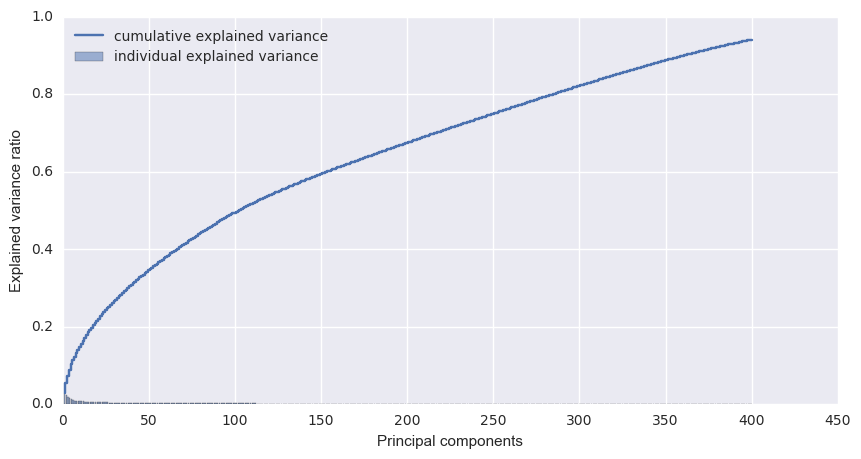

In [88]:
pca = PCA(n_components=None, random_state=1)

pipe = make_pipeline(StandardScaler(), pca)
pipe.fit(X_train)
expl_var_ratio = pipe.named_steps["pca"].explained_variance_ratio_

plt.figure(1, figsize=(10, 5))
plt.clf()
plt.bar(range(1, 401), expl_var_ratio[:400], alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1,401), np.cumsum(expl_var_ratio)[:400], where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [89]:
np.sum(expl_var_ratio[:400])

0.94107606282001721

As we can see from the plot above, the first 400 principal components are able to explain about 94 percent of the variance in the data. Let's now fit a logistic regression with PCA preprocessing with these 400 principal components:


In [87]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
pca = PCA(n_components=300, random_state=1)
pipe = make_pipeline(StandardScaler(), pca, StandardScaler(), logreg)

Cs = np.logspace(-3, 2, 6)
param_grid = {'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__C': Cs}

pca_logreg = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=4)
pca_logreg_scores = cross_val_score(pca_logreg, X_train, y_train,
                                    scoring='accuracy', cv=3, n_jobs=4)

print('Cross validated accuracy of Logistic Regression after PCA and StandardScaler preprocessing: \n %.3f +/- %.3f' %
      (np.mean(pca_logreg_scores), np.std(pca_logreg_scores)))

Cross validated accuracy of Logistic Regression after PCA and StandardScaler preprocessing: 
 0.680 +/- 0.003


100 principal components - accuracy: 0.667 +/- 0.002:
start - 18:29
finish - 19:08
39 minutes

300 principal components - accuracy: 0.680 +/- 0.003:
start - 19:13
finish - 06:50
11 hours 40 minutes

In [93]:
forest = RandomForestClassifier(n_estimators=1000, oob_score=1, n_jobs=4,
                                random_state=1)
pca = PCA(n_components=300, random_state=1)

param_grid = {'randomforestclassifier__max_features': ['log2', 'sqrt']}
pipeforest = make_pipeline(StandardScaler(), pca, forest)
pca_forest = GridSearchCV(estimator=pipeforest, param_grid=param_grid,
                          cv=3, n_jobs=6)
pca_forest_scores = cross_val_score(pca_forest, X_train, y_train,
                                    scoring='accuracy', cv=3, n_jobs=6)

print('Cross validated accuracy of Random Forest after PCA and StandardScaler preprocessing: \n %.3f +/- %.3f' %
      (np.mean(pca_forest_scores), np.std(pca_forest_scores)))

Cross validated accuracy of Random Forest after PCA and StandardScaler preprocessing: 
 0.675 +/- 0.002


300 principal components - accuracy: 0.675 +/- 0.002:
start - 08:02
finish - 08:42
40 minutes

In [94]:
scores = cross_val_score(forest, X_train, y_train, scoring='accuracy', cv=5,
                         n_jobs=-1)
print("Cross-validation Random Forest accuracy: {}".format(scores))
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Cross-validation scores: [ 0.69814674  0.69939897  0.69794225  0.69486789  0.69767048]
Accuracy: 0.698 (+/- 0.003)


An all-in-one grid search to select the best model between a Logistic Regression and a Random Forest with its respective best parameters. For the Logistic Regression model we also include an option of preprocessing with a StandardScaler, which will demean the observations and divide by their standard deviation. (will take quite a while to run):

In [ ]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
forest = RandomForestClassifier(oob_score=1, n_jobs=-1, random_state=0)
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', logreg)])

param_grid = [
              {'classifier': [logreg],
               'preprocessing': [StandardScaler(), None],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10]},
              {'classifier': [forest],'preprocessing': [None],
               'classifier__n_estimators': [100, 250, 500],
               'classifier__max_features': ['sqrt', 'log2']}]

all_in_one_grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
all_in_one_grid.fit(X_train, y_train)
print("Best parameters:\n{}\n".format(all_in_one_grid.best_params_))
print("Best cross-validation score: {:.2f}".format(all_in_one_grid.best_score_))
print("Test-set score: {:.2f}".format(all_in_one_grid.score(X_test, y_test)))

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Rustam\Anaconda3\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Users\Rustam\Anaconda3\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Rustam\Anaconda3\lib\multiprocessing\pool.py", line 429, in _handle_results
    task = get()
  File "C:\Users\Rustam\Anaconda3\lib\multiprocessing\connection.py", line 251, in recv
    return ForkingPickler.loads(buf.getbuffer())
  File "sklearn\tree\_tree.pyx", line 654, in sklearn.tree._tree.Tree.__setstate__ (sklearn\tree\_tree.c:8453)
MemoryError: resizing tree to 27041

